# 사전학습된 OCR 공개구현체 사용 실습

사전학습된 OCR 공개구현체를 Custom dataset을 사용해서 fine-tuning하는 실습을 수행하겠습니다.

이 실습에서는 Fausto Morales가 작성한 Keras OCR 공개구현체를 학습 목적에 맞게 수정한 버전을 사용합니다.

Copyright: https://github.com/faustomorales/keras-ocr/blob/master/docs/examples/using_pretrained_models.rst 의 공개구현체를 학습 목적에 맞도록 수정 (2022.11월, 김상호)


---

Keras OCR을 설치합니다.


*   2024.11.18 시점에 keras_ocr_recognition.Recognizer()에서 에러가 발생하여, 맨위에서 tensorflow, keras, keras_ocr의 버전을 다운 그레이드함.



OCR 라이브러리와, OCR결과를 화면으로 보여줄 plot 라이브러리를 import합니다.

In [1]:
import keras_ocr
import matplotlib.pyplot as plt
import os
data_dir = '.'

2024-12-13 03:55:34.713450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 03:55:34.723820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734029734.734987  128929 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734029734.738440  128929 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 03:55:34.750345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

간결한 실행문 한줄로 문자 위치를 찾는 detector에 이어서 문자를 인식하는 recognizer로 연결되는 Keras OCR pipeline을 구성하고, pre-trained weights까지 자동으로 다운로드해 옵니다.


In [2]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/kyudan/.keras-ocr/craft_mlt_25k.h5


I0000 00:00:1734029739.553142  128929 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Looking for /home/kyudan/.keras-ocr/crnn_kurapan.h5



**Option** : 만일 Keras OCR의 default weights가 아닌 본인의 weights로 OCR을 실행하고 싶다면, 먼저 weights가 담긴 파일을 Colab에 업로드하고, 아래의 cell에서 detector와 recognizer weights 파일명을 수정하고 실행하면 됩니다.

Keras OCR의 dafault weights를 사용하고 싶다면 아래 셀은 skip합니다.

In [46]:
# 본인의 weights로 detector and/or recognizer를 실행할 수 있습니다.
detector = keras_ocr.detection.Detector()
detector.model.load_weights('USE_detector_icdar2013-2024-12-13-01-33_fin.weights.h5')

recognizer = keras_ocr.recognition.Recognizer()
recognizer.model.load_weights('USE_recognizer_borndigital_third_fin.weights.h5')


Looking for /home/kyudan/.keras-ocr/craft_mlt_25k.h5
Looking for /home/kyudan/.keras-ocr/crnn_kurapan.h5


In [53]:

# default scale = 2
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer, scale=1)

Keras에 내장된 ICDAR2013 문자인식용 데이터셋(이미지+문자 위치정보)을 읽어옵니다.

OCR 추론을 테스트할 이미지들을 읽어옵니다. 추론할 이미지 파일 이름을 리스트에 추가할 수 있는데, url을 지정해서 인터넷에 있는 이미지를 읽어올 수도 있고, Colab에 이미지를 업로드해서 'directory/filename'식으로 지정해도 됩니다.

In [48]:
# Read a set of example images
images = [
keras_ocr.tools.read(url) for url in [
'extracted/mydata_detection_data/images/car15.jpg',
'extracted/mydata_detection_data/images/car16.jpg',
'extracted/mydata_detection_data/images/car17.jpg',
'extracted/mydata_detection_data/images/car18.jpg'
]
]

아래 셀을 실행하면, 읽어들인 이미지들에 대해 문자가 위치한 box position과 box내의 text를 인식합니다.

In [49]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'


In [50]:
# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


In [51]:
prediction_groups

[[('kcsim',
   array([[140., 184.],
          [256., 184.],
          [256., 244.],
          [140., 244.]], dtype=float32))],
 [('021mm',
   array([[352., 358.],
          [440., 358.],
          [440., 406.],
          [352., 406.]], dtype=float32))],
 [('18101',
   array([[ 28., 172.],
          [ 86., 172.],
          [ 86., 206.],
          [ 28., 206.]], dtype=float32))],
 [('sb3x6n',
   array([[ 82., 192.],
          [158., 192.],
          [158., 230.],
          [ 82., 230.]], dtype=float32))]]

OCR 추론 결과를 박스 및 인식된 문자와 함께 화면에 표시합니다.

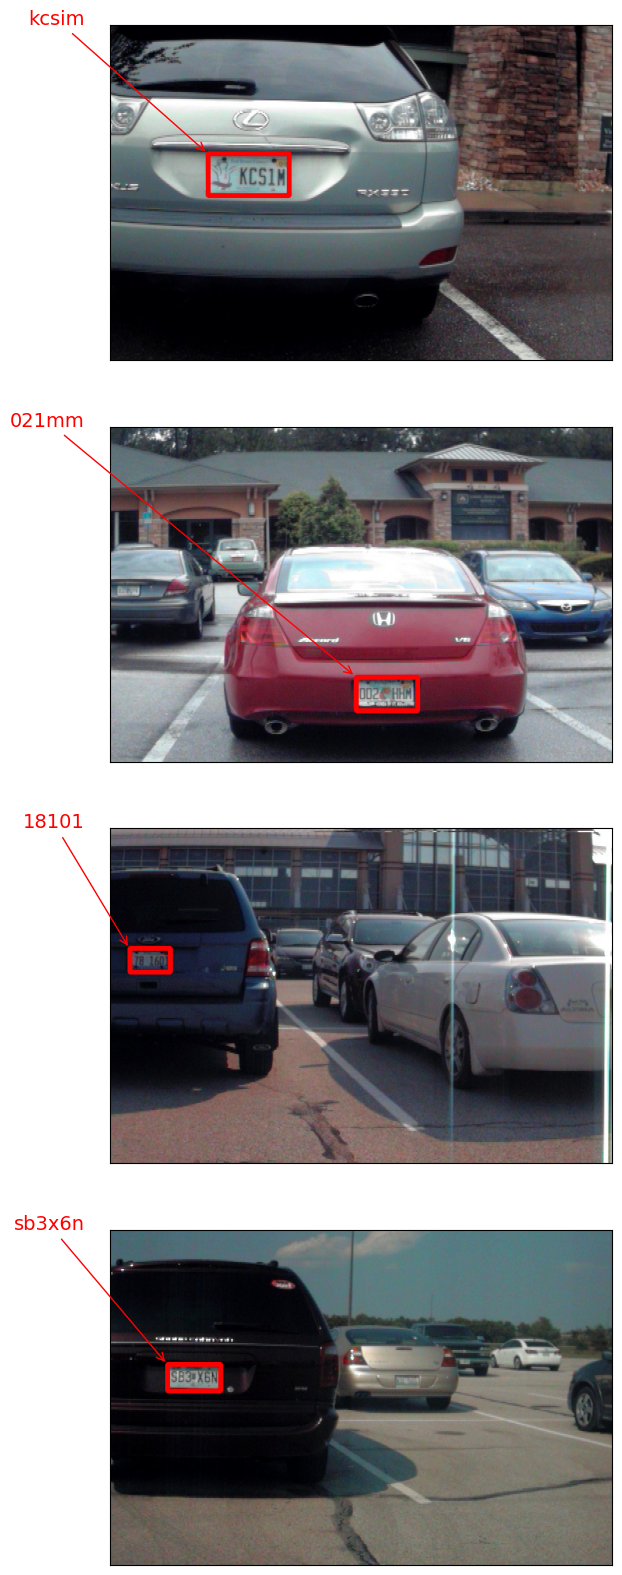

In [52]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)